In [1]:
# Import library
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
!pip install vnstock
from vnstock import *

In [2]:
# Import data
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
SSI
#SSI["Close"].plot()

Observations:  1640


,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2017-06-01,10590,10660,10530,10570,1888560,SSI
2017-06-02,10590,11040,10510,10950,5519180,SSI
2017-06-05,11000,11040,10740,10740,2811740,SSI
2017-06-06,10800,10910,10720,10870,2952940,SSI
2017-06-07,10950,11140,10930,10980,4110110,SSI
...,...,...,...,...,...,...
2023-12-11,32600,33050,32100,32700,19996900,SSI
2023-12-12,32800,33000,32500,32600,12453800,SSI
2023-12-13,32900,32950,32000,32000,21549400,SSI


In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
def preprocessing(data):
    df = data[["Close", "Volume"]]
    df = df.reset_index(drop = True)
    df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
    df['Volume'] = scaler.transform(np.array(df['Volume']).reshape(-1,1))
    print(df)
    return df

def SplitSet73(data):
    train_size = int(0.8*len(data))
    test_size = int(0.2*len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    print("Train data:\n", train_data.shape)
    print("Test data: \n", test_data.shape)
    return train_size, test_size, train_data, test_data
    

In [4]:
df = preprocessing(SSI)

         Close      Volume
0     0.118479   43.661025
1     0.127290  127.839555
2     0.122421   65.065616
3     0.125435   68.339439
4     0.127985   95.169256
...        ...         ...
1635  0.631579  463.515882
1636  0.629260  288.623696
1637  0.615349  499.511709
1638  0.615349  362.929284
1639  0.610712  460.596800

[1640 rows x 2 columns]


In [5]:
train_size = int(0.8*len(df))
test_size = int(0.2*len(df))
train_data = df[:train_size]
test_data = df[train_size:]
print("Train data:\n", train_data.shape)
print("Test data: \n", test_data.shape)

Train data:
 (1312, 2)
Test data: 
 (328, 2)


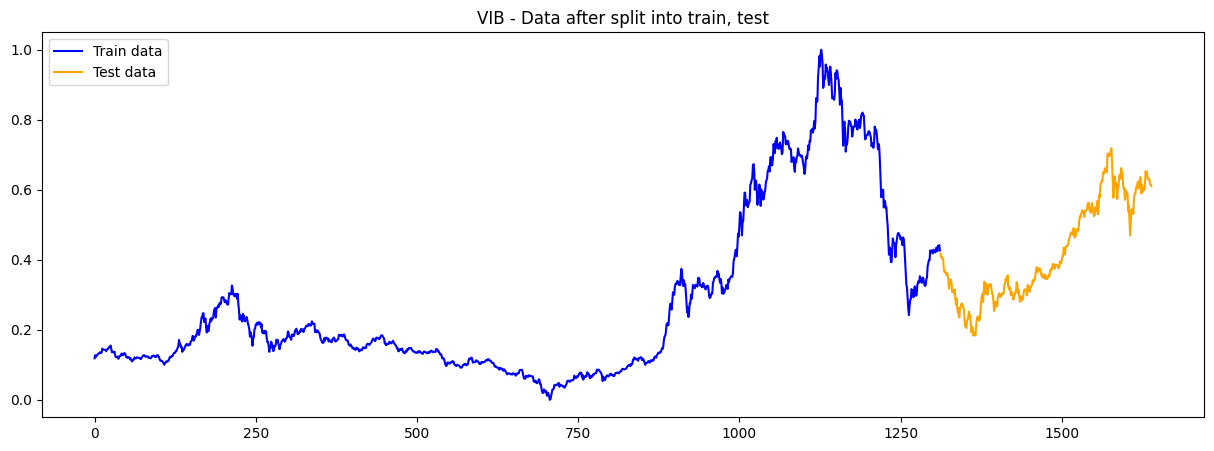

In [6]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Close'], 'b')
plt.plot(test_data.index, test_data['Close'], 'orange')
plt.legend(['Train data', 'Test data'], loc='upper left')
plt.title('VIB - Data after split into train, test')
plt.show()

In [7]:
model_var = VAR(train_data)
for i in range(1,10):
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  0.12237448531158138
BIC:  0.1460749223082116

Order = 2
AIC:  0.009161109077903991
BIC:  0.048686165690081065

Order = 3
AIC:  -0.11733527833031596
BIC:  -0.061966093668177985

Order = 4
AIC:  -0.17340834750916573
BIC:  -0.1021754869768197

Order = 5
AIC:  -0.19375154646245582
BIC:  -0.10663542274422103

Order = 6
AIC:  -0.19052819577498156
BIC:  -0.0875091819497551

Order = 7
AIC:  -0.18939913896389132
BIC:  -0.0704575683947696

Order = 8
AIC:  -0.19703550473783463
BIC:  -0.06215167096134355

Order = 9
AIC:  -0.19067663982663616
BIC:  -0.039830796441567756



In [8]:
result = model_var.fit(5)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 30, Dec, 2023
Time:                     22:31:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.106635
Nobs:                     1307.00    HQIC:                 -0.161074
Log likelihood:          -3560.49    FPE:                   0.823863
AIC:                    -0.193752    Det(Omega_mle):        0.810169
--------------------------------------------------------------------
Results for equation Close
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.000096         0.000564           -0.170           0.865
L1.Close          1.036533         0.027760           37.339           0.000
L1.Volume         0.000009         0.000005            1.823           0.068

In [9]:
lags_order = result.k_ar
lags_order

5

In [10]:
#Predict the price
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test_price = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[0].reshape(-1, 1)))
y_pred_test_vol = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[1].reshape(-1, 1)))
y_pred_test_price.shape

(323, 1)

In [11]:
number_of_days_to_predict = 60

In [12]:
ndays_pred = result.forecast(df[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

ndays_pred.shape

(60, 1)

In [13]:
y_test = test_data['Close'].values[lags_order:]
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_test.shape

(323, 1)

In [16]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

print("RSME test :", RSME(y_pred_test_price, y_test))
print("MAE test : ", MAE(y_pred_test_price, y_test))
print("MAPE test: ", MAPE(y_pred_test_price, y_test))
print("MSLR test: ", MSLE(y_pred_test_price, y_test))

RSME test : 748.9368204791986
MAE test :  559.9797359119153
MAPE test:  2.4705944888839566
MSLR test:  0.0010406394517658711


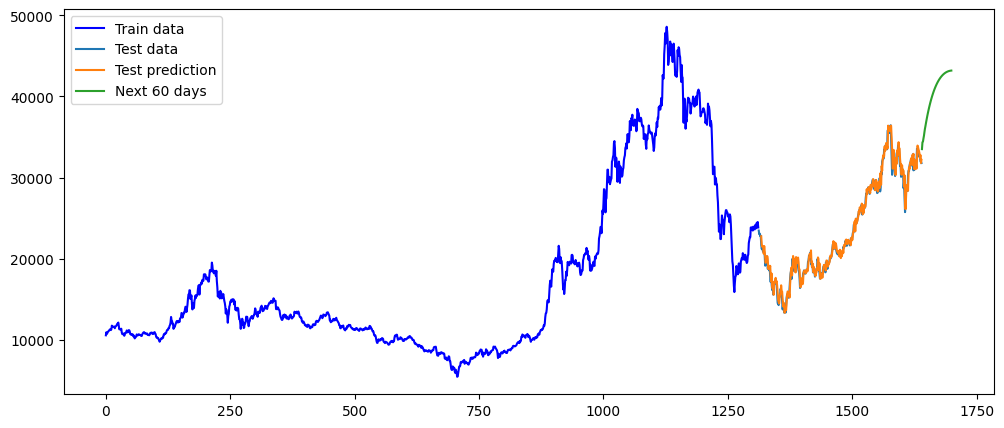

In [15]:
plt.figure(figsize=(12,5))
plt.plot(train_data.index, scaler.inverse_transform(np.array(train_data['Close']).reshape(-1, 1)), color="blue")
plt.plot(test_data.index, scaler.inverse_transform(np.array(test_data['Close']).reshape(-1, 1)).reshape(-1, 1))
plt.plot(test_data.index[-len(y_pred_test_price):], y_pred_test_price)
pred_ind = pd.RangeIndex(start = len(df['Close']), stop = len(df['Close'])+60)
plt.plot(pred_ind, ndays_pred)

plt.legend(["Train data", "Test data", "Test prediction", "Next 60 days"])
plt.show()